In [1]:
import zdb
import glob
import os
import oyaml as yaml

In [2]:
help(zdb.modules.analyse)

Help on function analyse in module zdb.modules.analyse:

analyse(config, mode='multiprocesing', ncores=0, nfiles=-1, batch_opts='', output=None, chunksize=500000, merge_opts={})



In [16]:
def generate_yaml(hists, selection, filepath, tables={"central": "Events"}, systs=[], mc=False):
    hists_def = {
        "_".join(k): [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k[0])},
            {"varname1": "df: '{}'".format(k[1])},
            {"varname2": "df: '{}'".format(k[2])},
            {"selection": "df: '{selection_name}'"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k[0])},
            {"binvar1": "df: df.{}_bin".format(k[1])},
            {"binvar2": "df: df.{}_bin".format(k[2])},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
        ] for k in hists
    }
    
    if mc:
        for key, hdef in hists_def.items():
            for label, vari in systs:
                hdef.extend([
                    {"sum_w_{}".format(label): "df: df.sum_w*({})".format(vari)},
                    {"sum_ww_{}".format(label): "df: (df.sum_w*({}))**2".format(vari)},
                ])
    
    monojet_inc_selection = selection + ["METTriggered"]
    if not mc:
        monojet_inc_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
    else:
        monojet_inc_selection.extend(["nTauSelection==0"])

    cutflows = {
        "MonojetInc": {
            "selection_name": "MonojetInc",
            "selection": "(" + ") & (".join(monojet_inc_selection) + ")",
            "weight": "1." if not mc else "df.Weight_MonojetInc",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                 "MTW", "MLL", "Muon", "Electron", "Tau",
            ])],
        },
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = [
        "df.HLT_IsoMu24", "df.HLT_IsoTkMu24",
    ]
    singleelectron_triggers = [
        "df.HLT_Ele27_WPTight_Gsf",
        "df.HLT_Ele115_CaloIdVT_GsfTrkIdT",
    ]

    cfg_eval_bins = [
        {"METnoX_pt_bin": "df: np.minimum(1550., np.floor(df.METnoX_pt/10.)*10.)"},
        {"MinDPhiJ1234METnoX_bin": "df: np.floor(df.MinDPhiJ1234METnoX/0.1)*0.1"},
        {"NearestJetSelectionMET_pt_bin": "df: np.minimum(1550., np.floor(df.NearestJetSelectionMET_pt/10.)*10.)"},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = [
            #"df.WeightOneMinusTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_tau_sele = [
            #"df.WeightTauSelectionIdTight",
            "df.WeightOneMinusTauVetoNoSelectionIdVLoose",
        ]
        weight_met_trig = ["df.WeightMETTrig",]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonCharge>0, np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEPlusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuPlusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHPlusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLPlusNu'), np.full_like(df.parent, 'WJetsToTauPlusNu'), ), ), np.full_like(df.parent, 'WJetsToLPlusNu'), ), ), ), np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToEMinusNu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuMinusNu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'WJetsToTauHMinusNu'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'WJetsToTauLMinusNu'), np.full_like(df.parent, 'WJetsToTauMinusNu'), ), ), np.full_like(df.parent, 'WJetsToLMinusNu'), ), ), ), ), np.where( df.parent=='DYJetsToLL', np.where(  df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'), ), ), ), np.full_like(df.parent, 'DYJetsToLL'), ), ), ), df.parent, ), ), df.parent, )"},
            {"Weight_MonojetInc": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_veto+weight_tau_veto+weight_met_trig)+")"},
        ])
        
    cfg_eval_bins.extend([
        {"METTriggered": "df: (" + ") | (".join(met_triggers) + ")"},
        {"SingleMuonTriggered": "df: (" + ") | (".join(singlemuon_triggers) + ")"},
        {"SingleElectronTriggered": "df: (" + ") | (".join(singleelectron_triggers) + ")"},
    ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "varname1", "varname2", "selection", "parent", "binvar0", "binvar1", "binvar2"],
            "tables": tables,
            "aliases": {},
            "eval": cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [17]:
hists = [("METnoX_pt", "MinDPhiJ1234METnoX", "NearestJetSelectionMET_pt")]
systs = []
data_selection = [
    "IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.5",
    "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1",
    "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "nPhotonVeto==0",
    "nBJetVeto==0", "METnoX_pt>200."
]
mc_selection = [
    "(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter",
    "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter",
    "Flag_BadPFMuonFilter", "MET_dCaloMET<0.5", "nJetSelection>0",
    "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8",
    "LeadJetSelection_pt>200.", "METnoX_pt>200.",
]

cfg_mc = generate_yaml(
    hists, mc_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc/*.h5",
    systs=systs, mc=True,
)
with open("configs/dists/cfg_data_met_mindphi_nearjetpt.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)
    
cfg_data = generate_yaml(
    hists, data_selection,
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/20_skims/data/*.h5",
    systs=[], mc=False,
)
with open("configs/dists/cfg_mc_met_mindphi_nearjetpt.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

## Submit

In [9]:
#zdb.modules.multi_analyse(
#    ["configs/hists/mc_inclusive.yaml"],
#    outputs=["dists_inclusive.h5:MCAggEvents"],
#    mode='sge',
#    ncores=400,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=250_000,
#    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": "-q hep.q"},
#)

## Draw

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools

plt.style.use("cms")

In [23]:
df = pd.read_hdf("hists3d_met_mindphi_nearjetpt.h5", "MCAggEvents")
df = df.loc[("central", "METnoX_pt", "MinDPhiJ1234METnoX", "NearestJetSelectionMET_pt", "MonojetInc"),:]

df = dftools.transform.merge(
    df, {
        "DYJetsToLL": [
            "DYJetsToEE", "DYJetsToMuMu", "DYJetsToTauHTauH", "DYJetsToTauHTauL", "DYJetsToTauLTauL",
        ],
        "WJetsToLNu": [
            "WJetsToEPlusNu", "WJetsToEMinusNu", "WJetsToMuPlusNu", "WJetsToMuMinusNu",
            "WJetsToTauLPlusNu", "WJetsToTauLMinusNu", "WJetsToTauHPlusNu", "WJetsToTauHMinusNu",
        ],
        "MinorBkgs": [
             "Diboson", "EWJV2Jets", "G1Jet", "SingleTop", "TTJets", "VGamma",
        ],
    }
)

met_bins = np.array([
    200, 220, 250, 280, 310, 340, 370, 400, 430, 470,
    510, 550, 590, 640, 690, 740, 790, 840, 900, 960,
    1020, 1090, 1160, 1250, 1400, 1550,
])
dphi_bins = np.arange(0., 2., 0.1)
jet_pt_bins = np.arange(0., 1000.1, 40.)

df = dftools.transform.rebin(df, met_bins, label="binvar0")
df = dftools.transform.rebin(df, dphi_bins, label="binvar1")
df = dftools.transform.rebin(df, jet_pt_bins, label="binvar2")

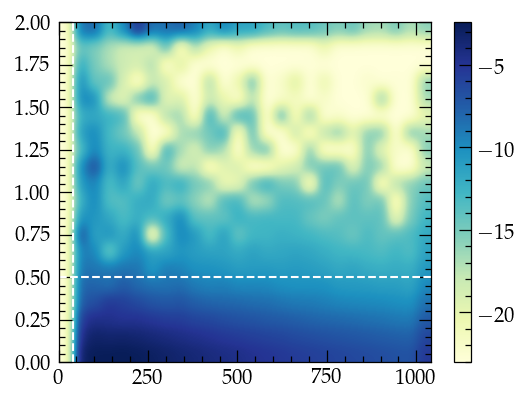

In [109]:
# Inclusive in ptmiss
df_draw = df.groupby(["parent", "binvar1", "binvar2"]).sum().loc[("QCD",), "sum_w"].unstack()
ybins = df_draw.index.get_level_values("binvar1").values
xbins = df_draw.columns.values
xbins = np.array(list(xbins)+[2*xbins[-1]-xbins[-2]])
ybins = np.array(list(ybins)+[2*ybins[-1]-ybins[-2]])
z = np.log(np.maximum(1e-10, df_draw.values/df_draw.values.sum()))

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

im = ax.imshow(
    z,
    cmap="YlGnBu",
    interpolation="gaussian",
    origin="lower",
    extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
    aspect='auto',
)
ax.axhline(0.5, lw=1, ls='--', color='white')
ax.axvline(40., lw=1, ls='--', color='white')

fig.colorbar(im, ax=ax)

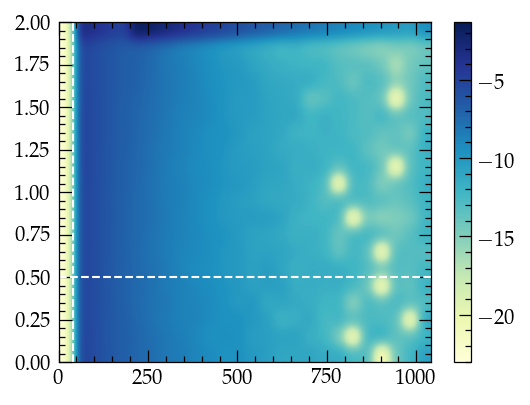

In [110]:
# Inclusive in ptmiss
df_draw = df.groupby(["parent", "binvar1", "binvar2"]).sum().loc[("ZJetsToNuNu",), "sum_w"].unstack()
ybins = df_draw.index.get_level_values("binvar1").values
xbins = df_draw.columns.values
xbins = np.array(list(xbins)+[2*xbins[-1]-xbins[-2]])
ybins = np.array(list(ybins)+[2*ybins[-1]-ybins[-2]])
z = np.log(np.maximum(1e-10, df_draw.values/df_draw.values.sum()))

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

im = ax.imshow(
    z,
    cmap="YlGnBu",
    interpolation="gaussian",
    origin="lower",
    extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
    aspect='auto',
)
ax.axhline(0.5, lw=1, ls='--', color='white')
ax.axvline(40., lw=1, ls='--', color='white')

fig.colorbar(im, ax=ax)

In [111]:
df_data = pd.read_hdf("hists3d_met_mindphi_nearjetpt.h5", "DataAggEvents")
df_data = df_data.loc[("central", "METnoX_pt", "MinDPhiJ1234METnoX", "NearestJetSelectionMET_pt", "MonojetInc"),:]

df_data = dftools.transform.rebin(df_data, met_bins, label="binvar0")
df_data = dftools.transform.rebin(df_data, dphi_bins, label="binvar1")
df_data = dftools.transform.rebin(df_data, jet_pt_bins, label="binvar2")

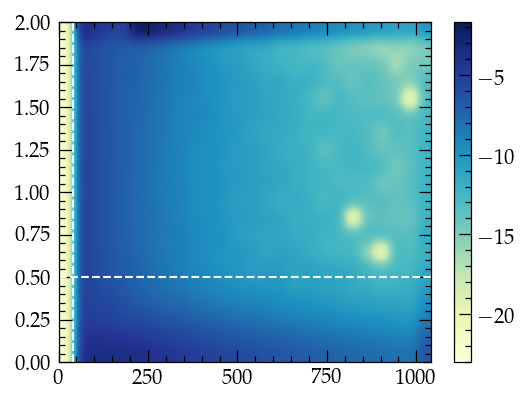

In [112]:
# Inclusive in ptmiss
df_draw = df_data.groupby(["binvar1", "binvar2"]).sum().loc[:, "sum_w"].unstack()
ybins = df_draw.index.get_level_values("binvar1").values
xbins = df_draw.columns.values
xbins = np.array(list(xbins)+[2*xbins[-1]-xbins[-2]])
ybins = np.array(list(ybins)+[2*ybins[-1]-ybins[-2]])
z = np.log(np.maximum(1e-10, df_draw.values/df_draw.values.sum()))

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

im = ax.imshow(
    z,
    cmap="YlGnBu",
    interpolation="gaussian",
    origin="lower",
    extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]),
    aspect='auto',
)
ax.axhline(0.5, lw=1, ls='--', color='white')
ax.axvline(40., lw=1, ls='--', color='white')

fig.colorbar(im, ax=ax)